# Training Comparison: Active Users Threshold

This notebook compares model performance with different definitions of "active users":
- **Regime 1**: Active users have >= 4 reviews
- **Regime 2**: Active users have >= 8 reviews

Both use temporal user-stratified splitting (1 test sample per user).

### Results Summary

| Regime | Users | Train Samples | Test Samples | RMSE | MAE | R² |
|--------|-------|---------------|--------------|------|-----|-----|
| **Active Users ≥ 4** | 231,518 | 1,559,764 | 231,518 | 1.0477 | 0.6339 | 0.2653 |
| **Active Users ≥ 8** | 61,272 | 894,867 | 61,272 | 1.1097 | 0.7313 | 0.2853 |

### Key Findings

1. **Trade-off between data quantity and user quality**: The k≥4 regime has 3.8× more users and 1.7× more training samples, while k≥8 focuses on users with richer interaction histories.

2. **Lower threshold (k≥4) achieves better prediction accuracy**:
   - 6% lower RMSE (1.0477 vs 1.1097)
   - 13% lower MAE (0.6339 vs 0.7313)
   
3. **Higher threshold (k≥8) achieves better explained variance**:
   - 8% higher R² (0.2853 vs 0.2653)
   - Suggests better ability to capture user preference patterns when more history is available

4. **Training efficiency**: The k≥8 regime trains ~48% faster (66.5s vs 128.9s) due to smaller dataset size.

5. **Early stopping behavior**: Both regimes stopped at epoch 9-10 after restoring best weights from epochs 4-5, indicating similar convergence patterns despite different data scales.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Import project modules
from config import Config
from src.data_splitting import temporal_user_stratified_split
from src.training import train_and_evaluate

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

In [2]:
# Load train/test splits and combine them
train_df = pd.read_parquet(Config.PROCESSED_DATA_DIR / 'train.parquet')
test_df = pd.read_parquet(Config.PROCESSED_DATA_DIR / 'test.parquet')
full_df = pd.concat([train_df, test_df], ignore_index=True)
del train_df, test_df
gc.collect()

print(f"Loaded {len(full_df):,} reviews")
print(f"Columns: {list(full_df.columns)}")

Loaded 2,291,355 reviews
Columns: ['podcast_id', 'title', 'content', 'rating', 'author_id', 'created_at', 'auth_id_encoded', 'podcast_id_encoded', 'review_text', 'bert_embedding_all-MiniLM-L6-v2']


## 3. Model Configuration

In [3]:
# Model hyperparameters (same for both regimes)
model_config = {
    'embedding_dim': 64,
    'mlp_layers': [128, 64],
    'dropout_rate': 0.2,
    'freeze_pretrained': False,
    'l2_reg': 1e-5,
    'learning_rate': 0.0002
}

# Training parameters
BATCH_SIZE = 2048
EPOCHS = 30
VALIDATION_SPLIT = 0.15

## 4. Regime 1: Active Users >= 4 Reviews

In [4]:
# Split data for active users with >= 4 reviews
train_df_4, test_df_4 = temporal_user_stratified_split(
    full_df,
    user_col='author_id',
    time_col='created_at',
    active_users_k=4
)

Total users: 398,209
Active users (>= 4 reviews): 231,518
Total reviews from active users: 1,791,282

Split Statistics:
  Training: 1,559,764 reviews
  Test:     231,518 reviews
  Total:    1,791,282 reviews


In [5]:
# Train model for regime 1
results_4 = train_and_evaluate(
    train_df_4,
    test_df_4,
    model_config,
    'Active Users >= 4',
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)


Training: Active Users >= 4
Users: 231,518
Podcasts: 158,658
Train samples: 1,559,764
Test samples: 231,518

Aggregating embeddings...

Training...
Epoch 1/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 18.8066 - mae: 4.0704 - val_loss: 5.4941 - val_mae: 2.2371 - learning_rate: 2.0000e-04
Epoch 2/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 4.0835 - mae: 1.6687 - val_loss: 1.2945 - val_mae: 0.7203 - learning_rate: 2.0000e-04
Epoch 3/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 1.5344 - mae: 0.8946 - val_loss: 1.2782 - val_mae: 0.6950 - learning_rate: 2.0000e-04
Epoch 4/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 1.1458 - mae: 0.7552 - val_loss: 1.2738 - val_mae: 0.6910 - learning_rate: 2.0000e-04
Epoch 5/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.9335 - mae: 0.6696 - val_loss: 1.2847 - val_mae: 0.6723 - learning_rate: 2.0000e-04
Epoch 6/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.7872 - mae: 0.6067 - val_loss: 1.2941 - val_ma

## 5. Regime 2: Active Users >= 8 Reviews

In [6]:
# Split data for active users with >= 8 reviews
train_df_8, test_df_8 = temporal_user_stratified_split(
    full_df,
    user_col='author_id',
    time_col='created_at',
    active_users_k=8
)

Total users: 398,209
Active users (>= 8 reviews): 61,272
Total reviews from active users: 956,139

Split Statistics:
  Training: 894,867 reviews
  Test:     61,272 reviews
  Total:    956,139 reviews


In [7]:
# Train model for regime 2
results_8 = train_and_evaluate(
    train_df_8,
    test_df_8,
    model_config,
    'Active Users >= 8',
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)


Training: Active Users >= 8
Users: 61,272
Podcasts: 113,323
Train samples: 894,867
Test samples: 61,272

Aggregating embeddings...

Training...
Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 20.0562 - mae: 4.2478 - val_loss: 16.8344 - val_mae: 3.9037 - learning_rate: 2.0000e-04
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 11.2418 - mae: 3.1181 - val_loss: 4.9265 - val_mae: 2.1025 - learning_rate: 2.0000e-04
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.4893 - mae: 1.5509 - val_loss: 1.4603 - val_mae: 0.8297 - learning_rate: 2.0000e-04
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.6441 - mae: 0.9630 - val_loss: 1.4221 - val_mae: 0.8251 - learning_rate: 2.0000e-04
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.3208 - mae: 0.8500 - val_loss: 1.4163 - val_mae: 0.7979 - learning_rate: 2.0000e-04
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1154 - mae: 0.7710 - val_loss: 1.4212 - val_mae: 0.79

## 6. Results Comparison

In [8]:
# Create comparison DataFrame
comparison = pd.DataFrame([
    {
        'Regime': results_4['regime'],
        'Users': results_4['n_users'],
        'Podcasts': results_4['n_podcasts'],
        'Train Samples': results_4['train_samples'],
        'Test Samples': results_4['test_samples'],
        'RMSE': results_4['rmse'],
        'MAE': results_4['mae'],
        'R²': results_4['r2'],
        'Training Time (s)': results_4['training_time']
    },
    {
        'Regime': results_8['regime'],
        'Users': results_8['n_users'],
        'Podcasts': results_8['n_podcasts'],
        'Train Samples': results_8['train_samples'],
        'Test Samples': results_8['test_samples'],
        'RMSE': results_8['rmse'],
        'MAE': results_8['mae'],
        'R²': results_8['r2'],
        'Training Time (s)': results_8['training_time']
    }
])

print("\n" + "="*80)
print("RESULTS COMPARISON: Active Users Threshold")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)


RESULTS COMPARISON: Active Users Threshold
           Regime  Users  Podcasts  Train Samples  Test Samples     RMSE     MAE       R²  Training Time (s)
Active Users >= 4 231518    158658        1559764        231518 1.047655 0.63393 0.265326         128.862096
Active Users >= 8  61272    113323         894867         61272 1.109719 0.73128 0.285307          66.530932


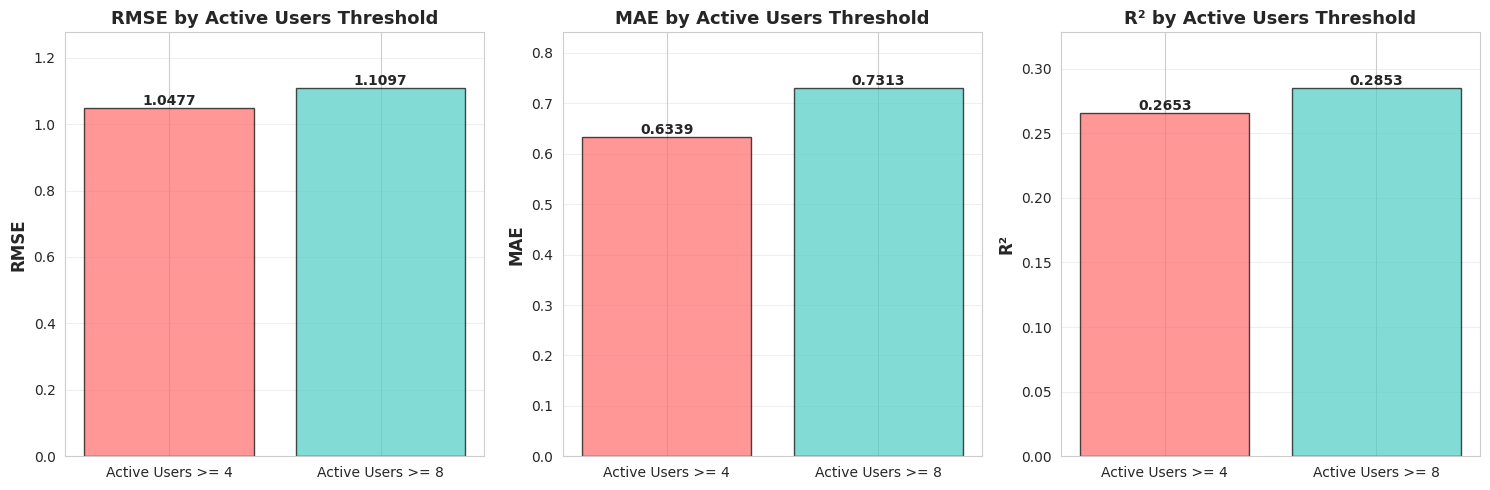

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['#FF6B6B', '#4ECDC4']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = comparison[metric].values
    bars = ax.bar(comparison['Regime'], values, color=colors, alpha=0.7, edgecolor='black')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} by Active Users Threshold', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

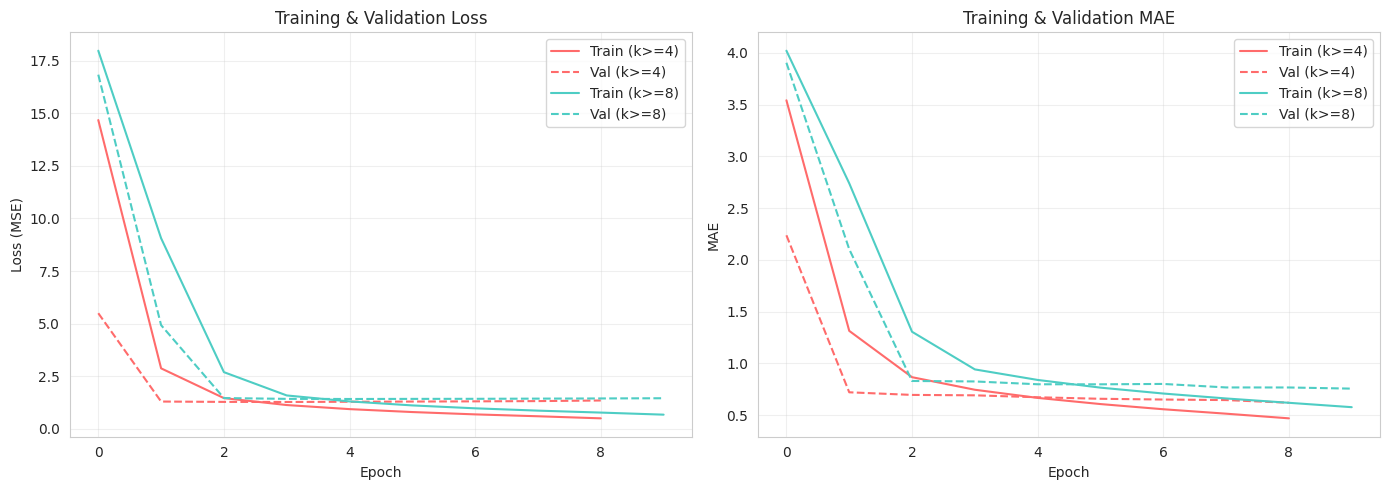

In [10]:
# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax = axes[0]
ax.plot(results_4['history']['loss'], label='Train (k>=4)', color='#FF6B6B')
ax.plot(results_4['history']['val_loss'], label='Val (k>=4)', color='#FF6B6B', linestyle='--')
ax.plot(results_8['history']['loss'], label='Train (k>=8)', color='#4ECDC4')
ax.plot(results_8['history']['val_loss'], label='Val (k>=8)', color='#4ECDC4', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training & Validation Loss')
ax.legend()
ax.grid(alpha=0.3)

# MAE
ax = axes[1]
ax.plot(results_4['history']['mae'], label='Train (k>=4)', color='#FF6B6B')
ax.plot(results_4['history']['val_mae'], label='Val (k>=4)', color='#FF6B6B', linestyle='--')
ax.plot(results_8['history']['mae'], label='Train (k>=8)', color='#4ECDC4')
ax.plot(results_8['history']['val_mae'], label='Val (k>=8)', color='#4ECDC4', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.set_title('Training & Validation MAE')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Model

In [11]:
models_dir = Config.DATA_DIR / 'models'
os.makedirs(models_dir, exist_ok=True)

# Save the model for 'Active Users >= 8'
model_8 = results_8['model']
model_8.save(os.path.join(models_dir, 'model_active_users_ge_8.keras'))

In [12]:
# Save the model for 'Active Users >= 4'
model_4 = results_4['model']
model_4.save(os.path.join(models_dir, 'model_active_users_ge_4.keras'))